In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from pathlib import Path

import em_utils.tdem_sounding as tdem_sounding
from simpeg.electromagnetics import time_domain as tdem
%matplotlib widget

# Lab 2 TEM Sounding inversions


Objectives
* Understand time-domain EM sounding responses to layered halfspaces.
  * How the subsurface conductivity effects the depth of investigation

* Understand how to include waveform information into a forward operation
* Invert SkyTEM data, and your ProTEM data.

## Part 1: TEM Sounding Modeling
We're going to start with some simple three layer models to investigate the resolution and depth of investigation of time-domain EM surveys

This next bit sets up a simple SimPEG TDEM Survey object using some basic parameters, most inversion algorithms will require similar bits of information.


#### Rx Times
* Let's say there's 51 time gates logarithmically spaced between 1E-6 and 1E-2 seconds

In [2]:
times = np.logspace(-6, -2, 51)

#### Receiver Type

Loops are often represented as point receivers sensitive to the $\partial \vec{B}/\partial T$.
* This receiver will be setup at the center of the loop (at the origin)
* It measures at certain times
* It measures are particular component of $\partial \vec{B}/\partial T$

In [3]:
rx = tdem.receivers.PointMagneticFluxTimeDerivative(locations=[0, 0, 0],times=times, orientation='Z')

#### Tx
Let's setup a 40m x 40m square loop, this is often done by specifying the nodes that would form a path for the wire.

Let's center it around the rx location

In [4]:
tx_shape = np.array([
    [-20.0, -20.0, 0],
    [20.0, -20.0, 0],
    [20.0, 20.0, 0],
    [-20.0, 20.0, 0],
    [-20.0, -20.0, 0],
])

Notice how the last point is the same as the first point. This implies it is a complete loop.

Transmitters also have *waveforms* associated with them.
For now let's use a step off waveform

In [5]:
wave_form = tdem.sources.StepOffWaveform()

Text(0.5, 0, 'Time (s)')

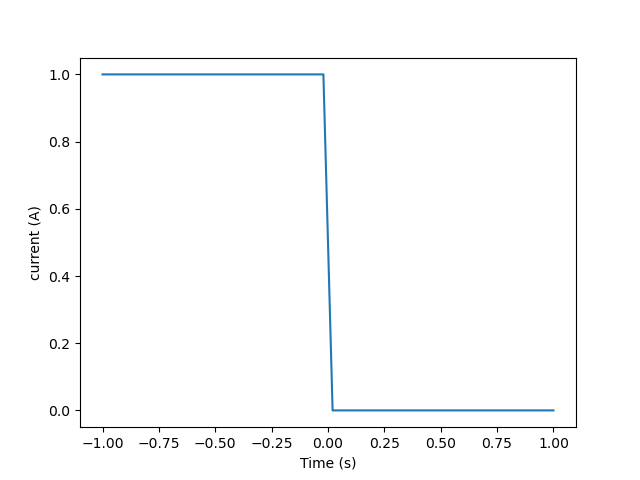

In [6]:
plt.figure()
t_plot = np.linspace(-1, 1)
plt.plot(t_plot, [ wave_form.eval(t) for t in t_plot])
plt.ylabel('current (A)')
plt.xlabel('Time (s)')

* The source is (multiple) lines of current, so let's use that source type

In [7]:
src = tdem.sources.LineCurrent(rx, location=tx_shape, current=1.0, waveform=wave_form)

### Survey Setup

* A simpeg `Survey` is basically a container for all of the sources in the survey.
* When there are multiple Tx moments, we'll often split them up into two different sources with different waveforms
* For now we have just one source

In [8]:
survey = tdem.Survey(src)

* This is a representation of where the source and receivers are at spacially

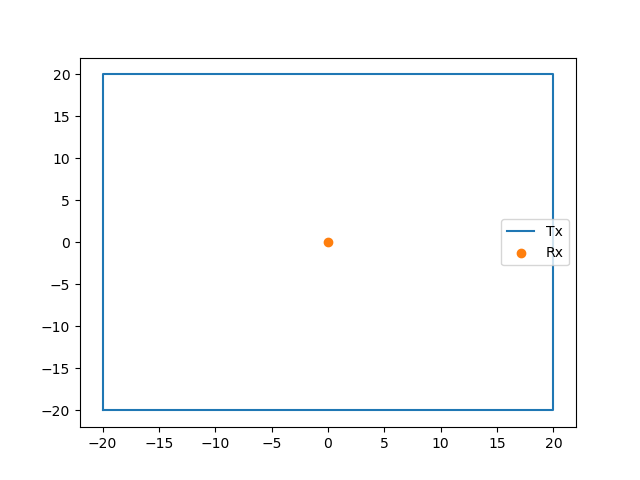

In [9]:
plt.figure()
plt.plot(*src.location[:, :-1].T, label='Tx')
plt.scatter(*rx.locations[:, :-1].T, color='C1', label="Rx")
plt.legend()

### Modeling!
Now let's investigate some models

A bit about this interactive widget:
* You can drag any of the lines to change their values
* You can insert a new node on any line by Shift+Right click (This inserts a new layer)
* You can drag the arrow downwards to give yourself more space to insert layers at the bottom
* If you pass `observed_voltages` to the constructor it will plot them as `+` on the right and enable the "Inversion" button.
* You can switch the right view window between volts and apparent conductivities
* Using the matplotlib controls:
    * The Home button returns you to the starting view
    * The Arrows will shift you between previous views
    * The box will zoom in on a "right click" selected square
    * The box will zoom out on a "left click" selected square
* You can retrieve the current model from the interactive widget using:
  `cond, thick = interact.get_model()`

In [10]:
interact_1 = tdem_sounding.TDEMSoundingInteract(survey,)

interact_1.set_model(conductivities=[1E-3, 1E-4], thicknesses=[100])
interact_1.display()

In [11]:
interact_1.get_model()

(array([0.001 , 0.0001]), array([100.]))

### Task 1:
* Adjust the depth of the layer until you can no longer see it in the data,

> Q: How does the curve on the right change as the bottom layer moves deeper?
>
> Q: What is this depth?
> 
> Q: How does this compare to the Tx side length?
> 

(Save an image of the model from the interactor and then insert it into this notebook)

In [12]:
# Now let's make the top layer much more conductive
interact_2 = tdem_sounding.TDEMSoundingInteract(survey,)

interact_2.set_model(conductivities=[1E-1, 1E-4], thicknesses=[100])
interact_2.display()

### Task 2:
* Again Adjust the depth of the layer until you can no longer see it in the data,

> Q: What is this depth?
> 
> Q: How does this compare to the depth in the previous task
>
> Q: How does conductivity effect the depth of investigation of a Time-Domain EM survey?

(Save an image of the model from the interactor and then insert it into this notebook)

In [13]:
# Back to the original model, this time though we're going to cutoff 20 of the later times
rx2 = tdem.receivers.PointMagneticFluxTimeDerivative(locations=[0, 0, 0],times=times[:-20], orientation='Z')
src2 = tdem.sources.LineCurrent(rx2, location=tx_shape, current=1.0, waveform=wave_form)
srv2 = tdem.Survey(src2)

interact_3 = tdem_sounding.TDEMSoundingInteract(srv2,)

interact_3.set_model(conductivities=[1E-3, 1E-4], thicknesses=[100])
interact_3.display()

### Task 3:
* Again adjust the depth of the layer until you can no longer see it in the data,

> Q: What is this depth?
> 
> Q: How does this compare to the depth in task 1
>
> Q: How does observation times effect the depth of investigation?

(Save an image of the model from the interactor and then insert it into this notebook)

## Part 2: ProTEM Inversion

For the ProTEM data inversion, we are only going to concern ourselves with the **Z** data components, let's gather them all up, but keep them separate by repetition rate (for now)

In [14]:
file_name = Path('data')/'lab1_protem.txt'
with open(file_name, 'r') as f:
    lines = f.readlines()

The Z component H data are in lines 6 through 10 of the data file.

Let's grab the voltages.

> **IMPORTANT** Only consider record lines associated with valid gain and current combinations! For the H repetition rate, this was at 4 amps and a gain of 6. For the u repetition rate, this was at 1 Amp and a gain of 1.

In [15]:
Hz_volts = []
for line in lines[5:10]:
    voltages = line[27:27+20*7]
    voltages = np.array([voltages[7*i:7*(i+1)] for i in range(20)], dtype=float)
    Hz_volts.append(voltages)
Hz_volts = np.asarray(Hz_volts)

In [16]:
plt.semilogy(Hz_volts.T);

### Task 4
Read in the u data as well

In [17]:
#TODO
# Do the same with the u repetition rate

uz_volts = []

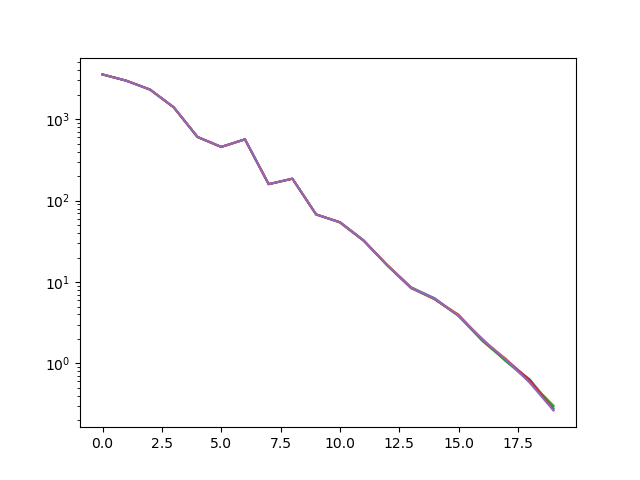

In [18]:
plt.figure()
plt.semilogy(uz_volts.T);

### get U and H data into nV/(m**2 * A)
* Assign times to each
* Normalize by currents and gains and rx_area

$$
v = \frac{v_{protem} 19200}{2^{n} I_{Tx} A_{Rx}}
$$

Where
* $v_{protem}$ is the voltage from the protem
* $n$ is the gain
* $I_{Tx}$ Is the transmitter current
* $A_{Rx}$ Is the receiver's effective area
* $V$ is then the normalized voltage in units of $nV/(m^2 A)$

> The 19200 is a calibration factor relevant for the ProTEM. 

### Task 5
* write a function to normalize the voltages

In [19]:
def normalize_voltages(volts, current, gain, rx_area):
    # TODO: Fill this out
    return ...

In [20]:
rx_area = 31.4

h_gain = 6
h_current = 4
hz_normed = normalize_voltages(Hz_volts, h_current, h_gain, rx_area)

u_gain = 1
u_current = 1
uz_normed = normalize_voltages(uz_volts, u_current, u_gain, rx_area)

Text(0, 0.5, 'Normalized voltage: $nV/(m^2 A)$')

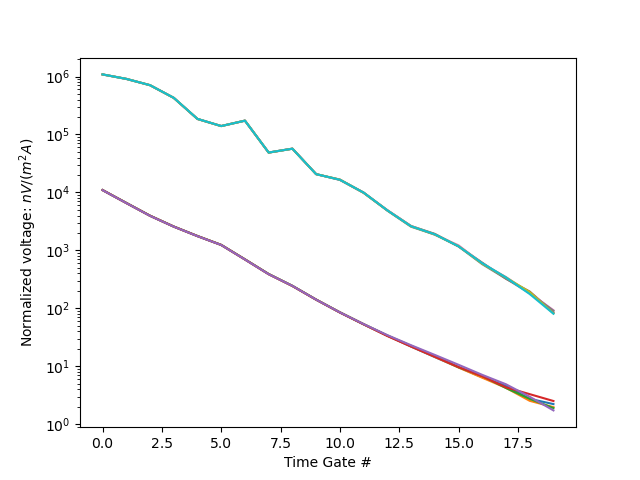

In [21]:
plt.figure()
plt.semilogy(hz_normed.T)
plt.semilogy(uz_normed.T)
plt.xlabel('Time Gate #')
plt.ylabel(r'Normalized voltage: $nV/(m^2 A)$')

Next we need to associate the correct times with each of the time gates.
These values can be found in the ProTEM's manual (for more repetiton rates as well), I've already copied them in for you for the H and u repetition rates

In [22]:
u_20_centers = np.array([6.813,8.688,11.13,14.19,18.07,23.06,29.44,
      37.56,47.94,61.13,77.94,99.38,126.7,166.4,206,262.8,
      335.2,427.7,545.6,695.9]) # in microseconds

In [23]:
H_20_centers = np.array([88.125,106.875,131.25,161.875,200.625,250.625,
      314.375,395.625,499.375,631.25,799.375,1013.75,1286.875,
      1635.625,2080.625,2648.125,3372.5,4296.875,5475.5,6978.5]) # in microseconds

> If you've normalized the voltages correctly up till here, the H repetition should follow on from the u repetiton rate.

Text(0, 0.5, 'Normalized voltage: $nV/(m^2 A)$')

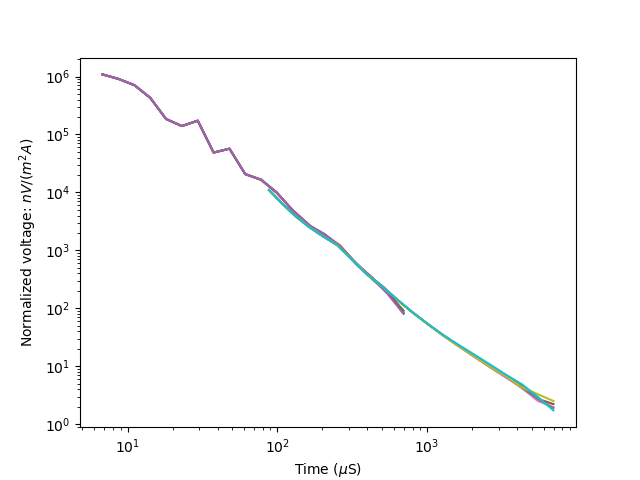

In [24]:
plt.figure()
plt.loglog(u_20_centers, uz_normed.T)
plt.loglog(H_20_centers, hz_normed.T);
plt.xlabel(r'Time ($\mu$S)')
plt.ylabel(r'Normalized voltage: $nV/(m^2 A)$')

Let's now average the 5 records of the data for each repetition together

In [25]:
u_means = uz_normed.mean(axis=0)
u_std = uz_normed.std(axis=0)
h_means = hz_normed.mean(axis=0)
h_std = hz_normed.std(axis=0)

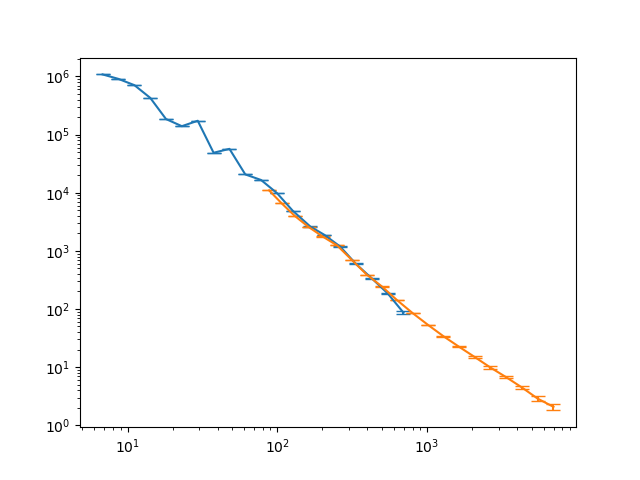

In [26]:
plt.figure()
plt.errorbar(u_20_centers, u_means, u_std, capsize=5)
plt.errorbar(H_20_centers, h_means, h_std, capsize=5)
plt.xscale('log')
plt.yscale('log')

### Task 6
> **Question** How does the error change for the early gates and the late gates? How does the error compare betweenn the H and u
> repetition rates?

### $\sigma_{app}$
Plot the late-time apparent conductivities for the averaged ProTEM data set! This can be useful for a starting point for inversions.

In [27]:
def app_cond_late_time(v, t, tx_area):
    """
    Parameters
    ----------
    v : normalized voltage in units of V/(m^2 A)
    t : time in seconds.
    tx_area : The transmitter area (m^2)s

    Notes
    -----
    Be careful about units here!
    """
    temp = v**2 * t**5 / (tx_area**2 * mu_0**5) * 20**2
    return temp**(1/3) * np.pi

Text(0.5, 0, 'time ($\\mu$s)')

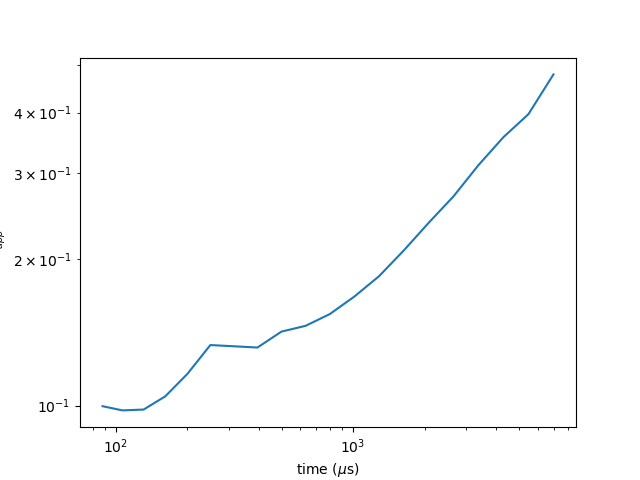

In [28]:
t = u_20_centers
sigma_a = app_cond_late_time(u_means*1E-9, t*1E-6, 40 * 40)
plt.loglog(t, sigma_a)

t = H_20_centers
sigma_a = app_cond_late_time(h_means*1E-9, t*1E-6, 40 * 40)
plt.figure()
plt.loglog(t, sigma_a)
plt.ylabel(r'$\sigma_{app}$')
plt.xlabel(r'time ($\mu$s)')

Now let's invert this data set!
* We start by setting up the simpeg survey object for this protem experience
* Compare this with how we set up the survey in our simple example before

In [29]:
### This sets up a simpeg survey for the ProTEM with the setup we used

# This is the shape of the 40 x 40 meter wire we used (Centered at 0)
tx_shape = np.array([
    [-20.0, -20.0, 0],
    [20.0, -20.0, 0],
    [20.0, 20.0, 0],
    [-20.0, 20.0, 0],
    [-20.0, -20.0, 0],
])

# This is different from before!
protem_waveform = tdem.sources.PiecewiseLinearWaveform([-2.5E-6, 0],[1, 0])

# Two different receivers for each of the different gates seems like a good organization approach
rx_u = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=u_20_centers*1E-6, orientation='Z'
)
rx_h = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=H_20_centers*1E-6, orientation='Z'
)

src = tdem.sources.LineCurrent(
    [rx_u, rx_h],
    location=tx_shape,
    waveform=protem_waveform,
    moment=40*40
)
src.moment = 40 * 40

protem_survey = tdem.Survey(src)

### Interactive inversion

* Now let's invert that data!
* Start up another interactive widget with passing observed values in

In [30]:
protem1 = tdem_sounding.TDEMSoundingInteract(
    protem_survey,
    observed_voltage=np.r_[u_means, h_means]*1E-9)
protem1.display()

### Task 7

Invert for a 2 layer model:
* Add another layer to the model (shift-click the line)
* Invert them!

> Save an image of your inverted model and attach it here

> **Q**: How do these results compare to your 1D DC sounding inversions from the previous semester?
> What might cause these differences?

Here's mine DC sounding inversion from before: (remember the bottom axis is resistivity, not conductivity)

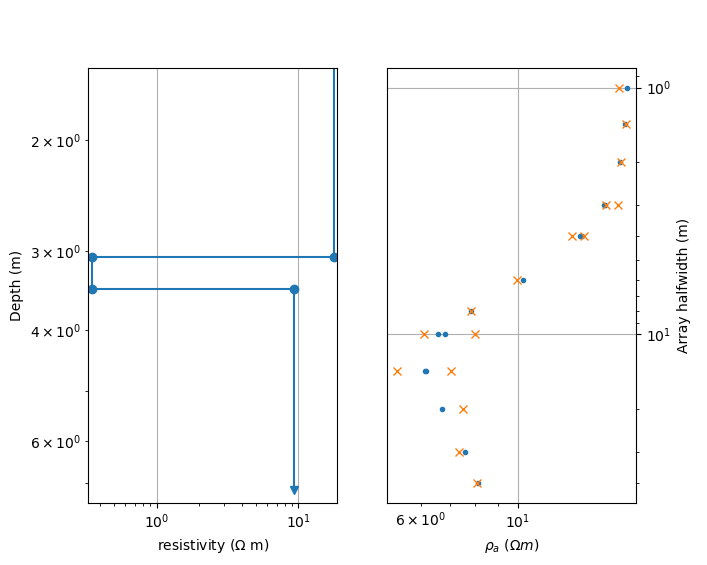

### Task 8
Add another layer and invert for a three layer model

> Insert the image again.

## Part 3: SkyTEM Inversion

Now let's use this approach to invert some sky-tem data!

From coastal California:

> **note** much of this comes from a simpeg tutorial I gave last year, check it out here: https://github.com/simpeg/segns-2024-tutorial

In [31]:
import pandas as pd
from em_utils.gex_parser import parse_gex_file

### Reading in the Data

First a bit about the skytem system. There are in general two sets of data:
* The low-moment data which is more sensitive to the near surface
* The high-moment data, which is (relatively) more sensitive to deeper structures.

The system has a hexagonal loop transmitter, with a $\frac{\partial \vec{B}}{\partial t}$ sensor.

There are two files that represent our data:
* A configuration file. Usually a `.gex` extension.
* The processed data file.
  * Simple CSV file $\rightarrow$ use `pandas`
 
We've provided a simple parser to read the information in the configuration file into python.

In [34]:
gex_file = parse_gex_file('data/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex')

In [35]:
gex_file

{'General': {'Description': 'Test geometry file',
  'GPSDifferentialPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition2': array([10.51,  3.95, -0.16]),
  'AltimeterPosition1': array([12.94,  1.79, -0.12]),
  'AltimeterPosition2': array([12.94, -1.79, -0.12]),
  'InclinometerPosition1': array([12.79,  1.64, -0.12]),
  'InclinometerPosition2': array([12.79,  1.64, -0.12]),
  'RxCoilPosition1': array([-13.25,   0.  ,  -2.  ]),
  'LoopType': 72,
  'FrontGateDelay': 2.5e-06,
  'TxLoopArea': 337.04,
  'NumberOfTurnsLM': 1,
  'NumberOfTurnsHM': 4,
  'RxCoilLPFilter1': array([9.9e-01, 2.1e+05]),
  'TxLoopPoints': array([[-12.64,  -2.13],
         [ -6.15,  -8.59],
         [  5.74,  -8.59],
         [ 11.13,  -3.19],
         [ 11.13,   3.19],
         [  5.74,   8.59],
         [ -6.15,   8.59],
         [-12.64,   2.13]]),
  'Waveforms': {'HM': {'time': array([-3.22220e-02, -3.17433e-02, -3.11906e-02, -3.04936e-02,
           -2.96885e-02

Can simply use `pandas.read_csv` to read in the data file

In [36]:
data_file = pd.read_csv('data/MCWD3_dat.xyz')
# you can alternatively use pandas to directly fetch this file from the internet
# data_file = pd.read_csv("https://github.com/simpeg/segns-2024-tutorial/raw/main/data/MCWD3_dat.xyz")
data_file

,LINE_NO,RECORD,UTMX,UTMY,TIMESTAMP,ELEVATION,ALT,INVALT,INVALTSTD,LM_DAT_00,...,HM_STD_18,HM_STD_19,HM_STD_20,HM_STD_21,HM_STD_22,HM_STD_23,HM_STD_24,HM_STD_25,HM_STD_26,HM_STD_27
0,100101,1,73305.896260,4.082421e+06,42873.747483,3.8,36.78,32.68,0.0224,1.657700e-08,...,0.0330,0.0353,0.0362,0.0367,0.0375,0.0381,0.0376,0.0394,0.0348,9999.0
1,100101,2,73337.025475,4.082420e+06,42873.747512,3.6,39.37,33.18,0.0193,1.598300e-08,...,0.0364,0.0360,0.0365,0.0371,0.0387,0.0388,0.0406,0.0410,0.0348,9999.0
2,100101,3,73361.647103,4.082401e+06,42873.747541,3.5,38.53,33.62,0.0202,1.477600e-08,...,0.0367,0.0365,0.0376,0.0379,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
3,100101,4,73378.387875,4.082370e+06,42873.747569,3.4,35.28,33.90,0.0243,1.472800e-08,...,0.0393,0.0379,0.0393,0.0391,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
4,100101,5,73395.783671,4.082335e+06,42873.747598,3.2,33.41,34.82,0.0248,1.278200e-08,...,0.0424,0.0401,0.0393,0.0391,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10605,212301,10606,83523.806947,4.076505e+06,42872.678588,35.7,38.96,41.34,0.0292,9.999000e+03,...,0.0386,0.0381,0.0373,0.0379,0.0388,0.0362,0.0380,9999.0000,9999.0000,9999.0
10606,212301,10607,83539.966456,4.076567e+06,42872.678617,35.9,41.35,44.34,0.0362,9.999000e+03,...,0.0372,0.0382,0.0358,0.0371,0.0368,0.0364,0.0380,9999.0000,9999.0000,9999.0
10607,212301,10608,83551.235351,4.076630e+06,42872.678646,35.8,44.19,47.13,0.0319,9.999000e+03,...,0.0360,0.0355,0.0350,0.0370,0.0366,0.0370,0.0380,9999.0000,9999.0000,9999.0
10608,212301,10609,83559.301122,4.076692e+06,42872.678675,35.2,47.19,50.22,0.0320,9.999000e+03,...,0.0347,0.0350,0.0344,0.0358,0.0372,0.0396,0.0402,9999.0000,9999.0000,9999.0


inside this data file, missing data are marked with the value 9999, let's replace them with NaNs instead (which the plotting utilities will then ignore).

In [37]:
data_file[data_file==9999] = np.NaN

Let's plot the location of all the stations in this survey

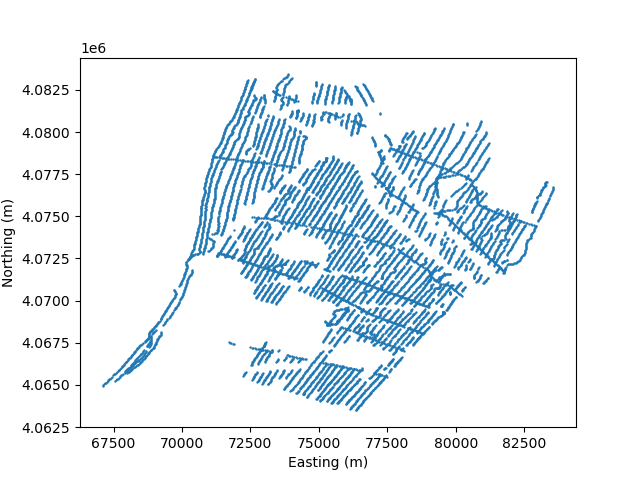

In [43]:
plt.figure()
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

A few bits of processing have already been done to this data set, in particular, they have been normalized for source current strength, normalized by the transmitter area, and have also been spatially averaged along flight lines to form "stations".

Now we need a bit of information from the `.gex` file to tell us the number of high moment and low moment time gates for this survey

In [39]:
n_lm_gates = gex_file['Channel1']['NoGates'] - gex_file['Channel1']['RemoveInitialGates']
n_hm_gates = gex_file['Channel2']['NoGates'] - gex_file['Channel2']['RemoveInitialGates']

The data file will have `n_lm_gates` of db/dt data, `n_lm_gates` of relative error estimates, then `n_hm_gates` of the high moment db/dt data, followed by `n_hm_gates` relative error estimates.

#### Zooming in to a single station to work with

Now let's look at a single station, along some randomly chosen line.

I can use panda's to easily group all of the data by a common line number
and then get that group

In [40]:
line_no = 206301
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)

Let's look at all the data along that line.

In [41]:
lm_data = line.iloc[:, 9:9+n_lm_gates]
hm_data = line.iloc[:, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]

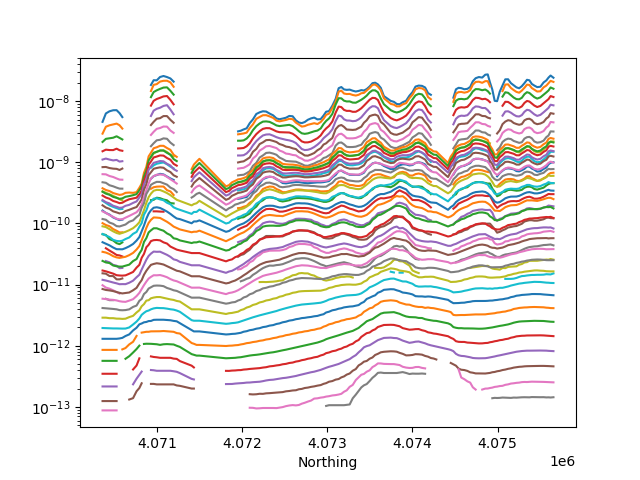

In [44]:
plt.figure()
plt.semilogy(line.UTMY, lm_data)
plt.semilogy(line.UTMY, hm_data)
plt.xlabel('Northing');

In [45]:
# select a single sounding along that line, and grab all of the data associated with that station
# Record 5590
station = line[line.RECORD==5590]
station_lm_data = station.iloc[0, 9:9+n_lm_gates].to_numpy()
station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates].to_numpy()
station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

Now we have numpy arrays of the recorded data for both the low and high moment data sets, along with their relative standard deviations.

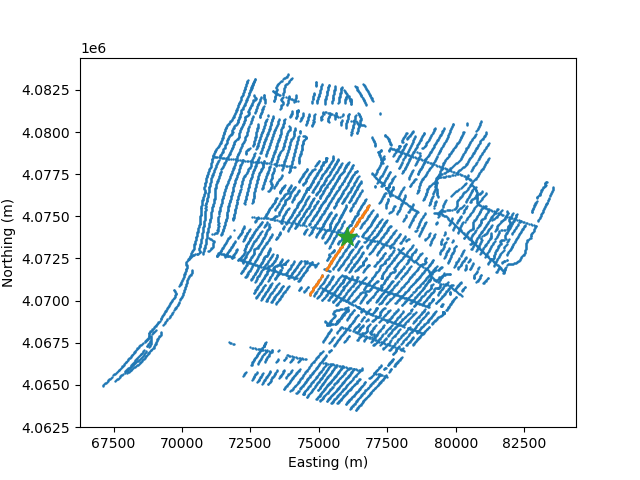

In [46]:
plt.figure()
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
plt.scatter(line.UTMX, line.UTMY, s=0.5)
plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

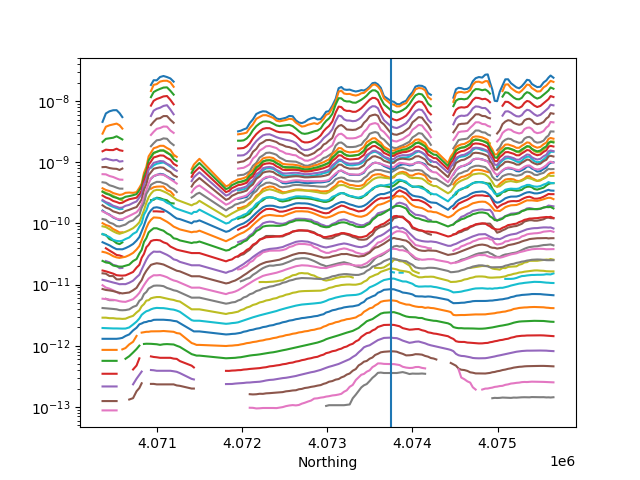

In [47]:
plt.figure()
plt.semilogy(line.UTMY, lm_data)
plt.semilogy(line.UTMY, hm_data)
plt.axvline(station.UTMY.iloc[0]);
plt.xlabel('Northing');

In order to model the data, we still need a few things pieces of information.
* The location in time of the measurements
* The transmitter waveforms
* The transmitter shape
* The receiver location

In [48]:
# In general the location of the gates is
# gate_time = gate_centers + shift + delay
# The Gex file also tells us which gates the respective moments use
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

Some of the station's data are NaN's (which represent no data), Let's remove those points from our consideration

In [49]:
lm_good_data = ~np.isnan(station_lm_data)
hm_good_data = ~np.isnan(station_hm_data)

lm_times = lm_times[lm_good_data]
hm_times = hm_times[hm_good_data]

station_lm_data = station_lm_data[lm_good_data]
station_lm_std = station_lm_std[lm_good_data]
station_hm_data = station_hm_data[hm_good_data]
station_hm_std = station_hm_std[hm_good_data]

# and of course reset our counts too
n_lm_gates = len(lm_times)
n_hm_gates = len(hm_times)

and finally plot some decay curves.

This is the data we will try to match.

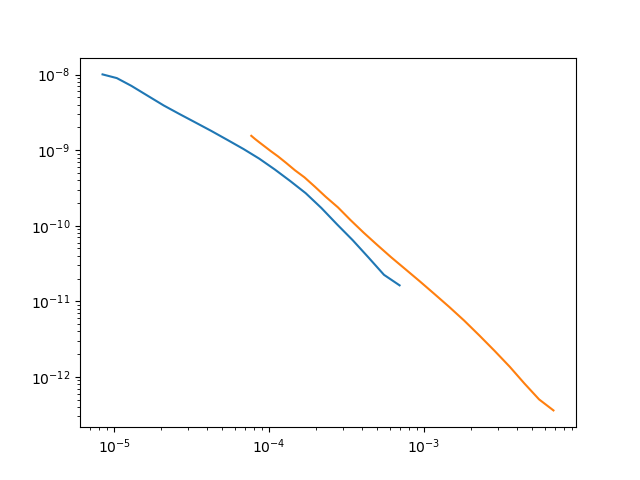

In [50]:
plt.figure()
plt.loglog(lm_times, station_lm_data)
plt.loglog(hm_times, station_hm_data)

#### Setting up the survey

Now we want represent all of the configuration with `SimPEG` objects.

SimPEG's general structure to hold this information is:
* Create `Receiver`s (that observe data)
* Create `Source`s (and attach receivers to those sources)
* Gather all the sources into a `Survey`

In the time-domain EM module:

* `Receivers`
    * Observe at a specific location in space.
    * Observe a specific component (Here it will be the vertical component of $\frac{d\vec{B}}{dt}$)
    * At specific times (the time-gate centers).
 
* `Sources`
    * Have specific types (Line Current, Magnetic Dipole, etc.)
    * Have a location (or set of locations for Line current)
    * Have waveforms
    * Are "listened to" by receivers.

So let's start by grabbing the information we will need from the gex file.

We already have the time gate locations. So, let's grab all of the information related to the transmitter.

Specifically here, the waveforms of the low and high moment sources.

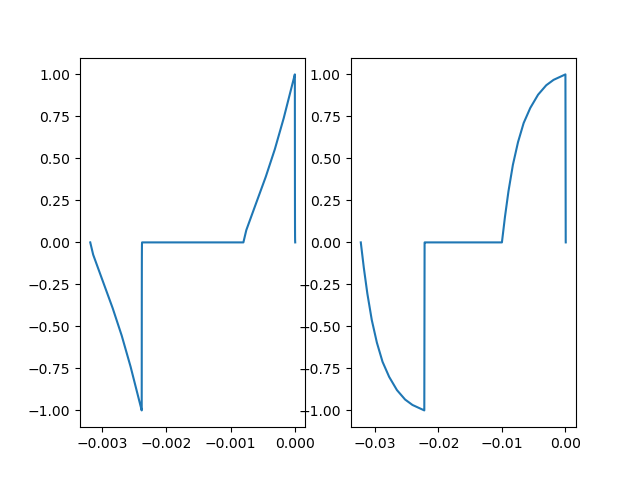

In [51]:
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']
plt.figure()
plt.subplot(121)
plt.plot(lm_wave_time, lm_wave_form)
plt.subplot(122)
plt.plot(hm_wave_time, hm_wave_form);

The shape of the transmitter , and the offset of the receiver coil.

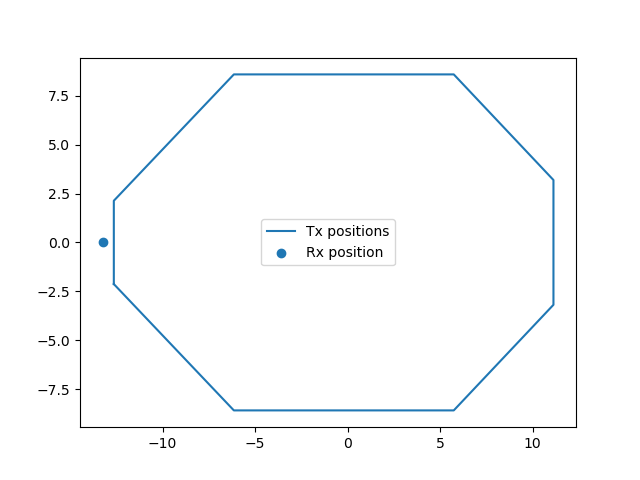

In [52]:
# We pad the locations of the Tx points with 0, to expand it from a 2D (x,y) pair to a 3D (x, y, z) pair.
# We also add another row because we will need to close the transmitter loop.
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]

rx_offset = gex_file['General']['RxCoilPosition1']

plt.figure()
plt.plot(*tx_shape[:, :-1].T, label='Tx positions')
plt.scatter(*rx_offset[:-1], label='Rx position')
plt.legend()

In [53]:
tx_shape

array([[-12.64,  -2.13,   0.  ],
       [ -6.15,  -8.59,   0.  ],
       [  5.74,  -8.59,   0.  ],
       [ 11.13,  -3.19,   0.  ],
       [ 11.13,   3.19,   0.  ],
       [  5.74,   8.59,   0.  ],
       [ -6.15,   8.59,   0.  ],
       [-12.64,   2.13,   0.  ],
       [-12.64,  -2.13,   0.  ]])

Let's give the transmitter and receiver explicit locations by adding the UTM coordinates of the station to the transmitter shape and the receiver offset.

In [54]:
tx_loc = tx_shape + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
rx_loc = rx_offset + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
# also let's grab the area
tx_area = gex_file['General']['TxLoopArea']

We are often asked how to deal with both the low and high moment data in SimPEG. The answer is actually fairly straightforward as long as you understand the structure of a SimPEG survey, we model them as two seperate sources (who just so happen to be in the same location).

In [55]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [56]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

Now we can set up a survey that has two sources!

In [57]:
srv = tdem.Survey([src_lm, src_hm])

In [59]:
dobs = tx_area * np.r_[station_lm_data, station_hm_data]

skytem_interact = tdem_sounding.TDEMSoundingInteract(srv, observed_voltage=dobs)
skytem_interact.display()

### Task 9
Run an inversion of the skytem data sounding choosing your own station

* Make your own choice for the number of layers
    * Observe how well it fits the data
    * Observe how much adding a layer changes the model

> Add an image!